# TP 3 : LINEAR REGRESSION

## EXERCICE 1 : Le jeu de données contaminé par le robot 

In [40]:
import pandas as pd
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Question 1

Importer la base de données data_dm3.csv disponible depuis le lien https://bitbucket.org/
portierf/shared_files/downloads/data_dm3.csv. La dernière colonne est la variable à expliquer.
Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives
et le nombre d’observations.

In [5]:
data = pd.read_csv("https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv", sep = ",", header = None)

In [6]:
explicated_var = pd.DataFrame(data.iloc[ : ,-1])
explicative_var = pd.DataFrame(data.drop(data.columns[-1], axis= 1))

In [7]:
print("Nombre d\'observations : ", explicative_var.shape[0], "\nNombre de variables explicatives : ", explicative_var.shape[1] )

Nombre d'observations :  442 
Nombre de variables explicatives :  210


### Question 2 

Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à expliquer ?
Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à
expliquer (un scatterplot regroupe les graphes de chacune des variables en fonction de chacune des
autres). Commenter les graphiques obtenus.

In [8]:
eps = 10**(-4) # Set a eps to compare to 0
if (all(abs(explicative_var.mean()) < eps)):
    print('Explicative variables are centered')
else: 
    print('Explicative variables not centered')
    
if (all(explicative_var.var() - 1 < 10**-2)):
    print('Explicative variables are standardized')
else: 
    print('Explicative variables not standardized')


Explicative variables are centered
Explicative variables are standardized


In [9]:
eps = 10**(-4) # Set a eps to compare to 0
if (all(abs(explicated_var.mean()) < eps)):
    print('Explicated variables are centered')
else: 
    print('Explicated variables not centered')
    
if (all(explicated_var.var() - 1 < 10**-2)):
    print('Explicated variables are standardized')
else: 
    print('Explicated variables not standardized')


Explicated variables not centered
Explicated variables not standardized


<IPython.core.display.Javascript object>


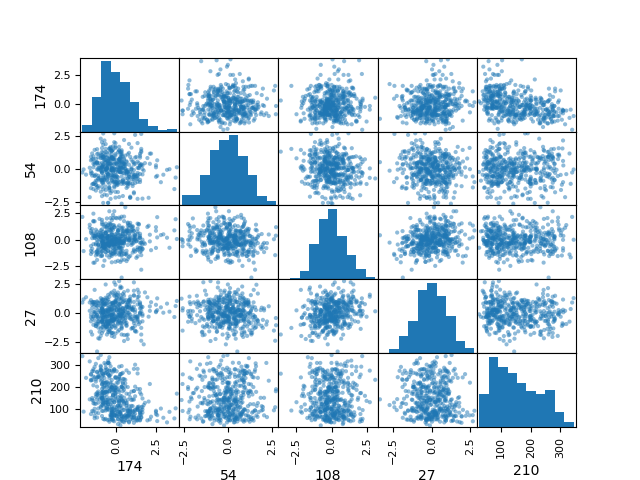

In [10]:
%matplotlib notebook
# Get 4 different columns randomly
random.seed(1234) # for reproducibility
rand_col = np.random.randint(0, len(explicative_var.columns), [4])
df_toplot = pd.concat([pd.DataFrame(explicative_var[rand_col]), explicated_var], axis = 1)
scatter_matrix(df_toplot)
plt.show()

Comment : TO DO

### Question 3

Echantillon d’apprentissage et de test. Créer 2 échantillons : un pour apprendre le modèle X train ,
un pour tester le modèle X test . On mettra 20% de la base dans l’échantillon ’test’. Donner les tailles
de chacun des 2 échantillons.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(explicative_var, explicated_var, test_size=0.20)

In [17]:
# Get sample size :
n_test = X_test.shape[0]
n_train = X_train.shape[0]
print('Train sample is ', n_train, '\nTest sample is ', n_test)

Train sample is  353 
Test sample is  89


### Question 4 

Donner la matrice des correlations calculée sur X train . Tracer le graphe de la décroissance des
valeurs propres de la matrice de corrélation. Expliquer pourquoi il est légitime de ne garder que les
premières variables de l’ACP. On gardera 60 variables dans la suite.

<IPython.core.display.Javascript object>


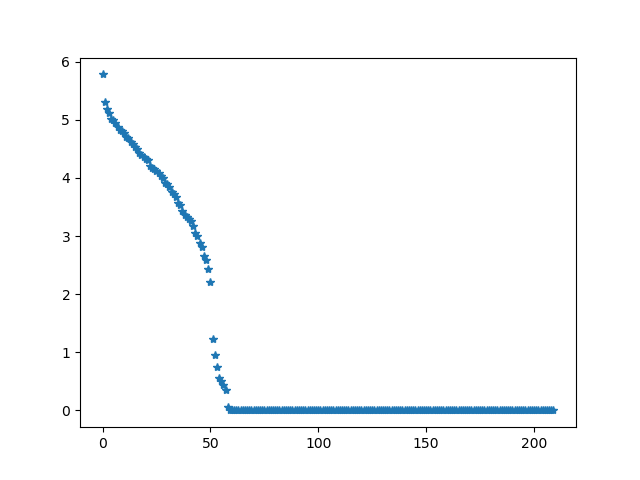

In [38]:
corr = X_train.corr()
eigenval, eigenvect = np.linalg.eig(corr)
plt.figure()
sorted_eigenval = eigenval.real.sort()
plt.plot(sorted(eigenval, reverse=True), '*')
plt.show()

We observe that from the 60th eigenvalue, they are virtually equal to 0. Which means the last variables have no impact in the global variance. 

In [58]:
# ACP analysis
a = PCA(n_components=60)
a.fit(X_train)
print(a.score)
print(a.singular_values_)


<bound method PCA.score of PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)>
[45.47958964 43.38006201 42.78368227 42.54563625 42.13878043 42.01181104
 41.80971712 41.51825611 41.27354787 41.18407601 40.96643473 40.79420023
 40.54738875 40.28902849 40.22824023 39.93002311 39.85274981 39.51893962
 39.32890279 39.0597607  39.01026658 38.82692027 38.47375268 38.34170315
 38.21851859 38.01247523 37.9408393  37.66173714 37.4319515  37.03732007
 36.83021585 36.59246196 36.1943781  36.10384695 35.89179776 35.41830009
 35.11837164 34.72360341 34.35904977 34.03435529 33.8564925  33.67312147
 33.27381015 32.59907708 32.34235813 31.6703749  31.22977494 30.35112412
 29.92797986 29.31538186 27.71649708 21.00473191 18.58452865 16.33566935
 14.25495597 13.40674316 12.44210687 11.34096506  4.83005546  1.55944297]


### Question 5

Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS" qui
consiste à faire une ACP avant la régression. Faire une régression linéaire (avec intercept), puis
tracer les valeurs des coefficients (hors intercept). Sur un autre graphique, faire de même avec la
méthode des moindres carrés classique.

### Question 6

### Question 7